# Digit classification with the Kernel Perceptron
Natalia Kartasheva (943350)

The project below is dedicated to the creation of a Kernel Perceptron and its implementation for multiclass classification and recognition of handwritten digits. The source of the training and test data is a MNIST dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Download the dataset

In [2]:
# define the fitting and validation sets
train = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')

train = train.sample(frac = 1)

X_train = train.iloc[:, 1:].to_numpy()
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:].to_numpy()
y_test = test.iloc[:, 0]

# We normalize the feature values through division by 255, so they range from 0 to 1.
X_train = X_train / 255
X_test = X_test / 255

## MyPerseptron
A class is created using the fit() and avg_predict() functions.

In [3]:
class MyPerseptron:
    
    def __init__(self):
        self.x_S = []
        self.y_S = []
        self.index_S = []
        
    # fit the model to recognize numbers
    def fit(self, x, y, epochs, degree):
    
        # numbers to recognize
        num_class = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        for n_class in num_class:

            print(f'Fit on number: {n_class}')
            # select images of the given number
            y_class = np.where(y == n_class, 1, -1)
            x_S = x[0]
            y_S = y_class[0]
            v = y_class[1]
            index = 0

            # going on dataset
            for epoch in range(epochs):
                # going on images
                for i in range(x.shape[0] - 1):
                    # add weights of image
                    if np.sign(np.sum(y_S.T * ((1 + x_S @ x[i+1])**degree))) != y_class[i+1]:
                        x_S = np.vstack( [x_S, x[i+1]] )
                        y_S = np.vstack( [y_S, y_class[i+1]] )
                        index = np.vstack( [index, ((i+1) + x.shape[0] * epoch)] )

            self.x_S.append(x_S)
            self.y_S.append(y_S)
            self.index_S.append(index)

        return self.x_S, self.y_S, self.index_S


    # consider average predictions
    def avg_predict(self, x, epochs):
        print('Start predictions')
        x_S_avg_pred = []
        y_S_avg_pred = []

        # going to images weights
        for i in range(len(self.x_S)):
            x_weight = self.x_S[i] * (((x.shape[0] * (epochs)) - self.index_S[i]) / (x.shape[0] * (epochs)))
            y_weight = self.y_S[i] * (((x.shape[0] * (epochs)) - self.index_S[i]) / (x.shape[0] * (epochs)))

            x_S_avg_pred.append(x_weight)
            y_S_avg_pred.append(y_weight)

        return x_S_avg_pred, y_S_avg_pred

    
    def polynomial_kernel(self, x, num, degree):
        return np.power( np.matmul(num, x.T), degree )
    
    
    def zero_one_metric(self, y_true, y_pred):
        pred = 1 - np.sum(np.array(x) == np.array(y)) / len(np.array(x))
        return pred

## Binary Classification
### Fit and finding an Average Predictor
## $$ h_\omega = sgn\left( \sum_{s \epsilon S} y_s \omega_s K(x_s \omega_s, x) \right) $$

In [ ]:
binary_model = MyPerseptron()

evaluate_train = []
evaluate_test = []

epochs = 5
degrees = [4, 5, 6, 7]

# going to every degree in degrees
for degree in degrees:
    print(f'Degree: {degree}')
    # fit the model
    binary_model.fit(X_train, y_train, epochs, degree)
    # consider average predictions
    x_avg, y_avg = binary_model.avg_predict(X_train, epochs)
    
    # consider the loss and metrics for every avg_predict
    for ind in range(len(x_avg)):
        y_train_eval = np.where(y_train == ind, 1, -1)
        y_test_eval = np.where(y_test == ind, 1, -1)
        
        # formula from hat
        h_w = np.sign(np.sum(y_avg[ind] * binary_model.polynomial_kernel(X_train, x_avg[ind], degree), axis=0))
        # consider zero_one metric
        metric = np.count_nonzero(h_w - y_train_eval) / X_train.shape[0]
        evaluate_train.append(metric)
        
        # formula from hat
        h_w = np.sign(np.sum(y_avg[ind] * binary_model.polynomial_kernel(X_test, x_avg[ind], degree), axis=0))
        # consider zero_one metric
        metric = np.count_nonzero(h_w - y_test_eval) / X_test.shape[0]
        evaluate_test.append(metric)

Degree: 4
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3


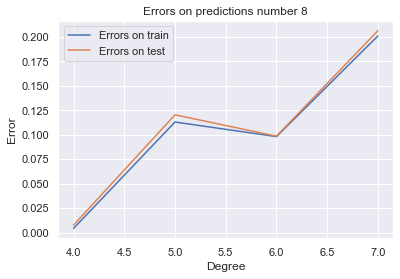

In [13]:
n = 8

sns.set_theme 
sns.lineplot(degrees, evaluate_train[n:40:10], label='Errors on train')
sns.lineplot(degrees, evaluate_test[n:40:10], label='Errors on test')

plt.title(f'Errors on predictions number {n}')
plt.ylabel('Error')
plt.xlabel('Degree')
plt.legend()

### Finding a Best Predictor
### At time t = T we have $ S_1, S_2, ..., S_T $ active sets of indices and we know that $ S_1 \subseteq S_2, ... S_T-1 \subseteq S_T $
### Defining the set of classifier as
### $$ h_1(x) = sgn\left( \sum_{s \epsilon S_1} y_s K(x_s, x) \right) $$
### $$ h_2(x) = sgn\left( \sum_{s \epsilon S_2} y_s K(x_s, x) \right) $$
### $$ . $$
### $$ . $$
### $$ . $$
### $$ h_T(x) = sgn\left( \sum_{s \epsilon S_T} y_s K(x_s, x) \right) $$
### Given $ \Omega = \{h_1, h_2, ..., h_T\} $ the best predictor is the one minimizing the training error formally
## $$ h_b(x) = \underset{h \in \Omega}{arg min} \frac{1}{T} \sum_{t=1}^T L(h(x_t),y_t) $$

In [17]:
number = 6

result_train_all = []
result_test_all = []

kernel_train = binary_model.polynomial_kernel(X_train, binary_model.x_S[number], 4)
kernel_test = binary_model.polynomial_kernel(X_test, binary_model.x_S[number], 4)

y_class = binary_model.y_S[number]
y_train_class = np.where(y_train == number, 1, -1)
y_test_class = np.where(y_test == number, 1, -1)

# get all results on train
for i in range(kernel_train.shape[0]):
    h = np.sign(np.sum(y_class[:i] * kernel_train[:i], axis=0))
    result_train_all.append(np.count_nonzero(h - y_train_class))

# get all results on test
for i in range(kernel_test.shape[0]):
    h = np.sign(np.sum(y_class[:i] * kernel_test[:i], axis=0))
    result_test_all.append(np.count_nonzero(h - y_test_class))
    
min_train = np.argmin( result_train_all )
min_test = np.argmin( result_test_all )

print(f'Min loss on ind {min_train} train: {min(result_train_all) / 60000}')
print(f'Min loss on ind {min_test} test: {min(result_test_all) / 10000}')

Min loss on ind 885 train: 0.0006
Min loss on ind 739 test: 0.0032


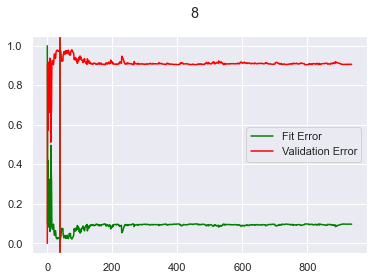

In [10]:
errors = plt.figure()
plt.plot(np.array(result_train_all)/60000, label = "Fit Error", color = "green")
plt.plot(1 - np.array(result_test_all)/10000, label = "Validation Error", color = "red")
plt.axvline(x = min_train, color = "green")
plt.axvline(x = min_test, color = "red")
errors.suptitle(str(n))
plt.legend()
plt.show()

## Multiclass Classification
### Fit and finding an Average Prediction

In [8]:
multi_model = MyPerseptron()

results = []

epochs_list = [5, 6, 7, 8, 9, 10]
degrees_list = [4, 5, 6, 7]

# going to every epoch in epochs
for epochs in epochs_list:
    print(f'Num of epochs: {epochs}')
    # going to every degree in degrees
    for degrees in degrees_list: 
        print(f'Degree: {degrees}')
        # fit the model
        multi_model.fit(X_train, y_train, epochs, degrees)
        # consider average predictions
        x_avg, y_avg = multi_model.avg_predict(X_train, epochs)
        
        projections = []
        # get predictions for test dataframe
        for ind in range(len(x_avg)): 
            p = np.sum(y_avg[ind] * multi_model.polynomial_kernel(X_test, x_avg[ind], degrees), axis=0)
            projections.append(p)
            
        projections = pd.DataFrame(projections).T
        # get best model
        y_hat = projections.idxmax(axis=1)
        # consider zero_one metric
        results.append(np.count_nonzero(y_hat - y_test))

Num of epochs: 5
Degree: 4
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3
Fit on number: 4
Fit on number: 5
Fit on number: 6
Fit on number: 7
Fit on number: 8
Fit on number: 9
Start predictions
Degree: 5
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3
Fit on number: 4
Fit on number: 5
Fit on number: 6
Fit on number: 7
Fit on number: 8
Fit on number: 9
Start predictions
Degree: 6
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3
Fit on number: 4
Fit on number: 5
Fit on number: 6
Fit on number: 7
Fit on number: 8
Fit on number: 9
Start predictions
Degree: 7
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3
Fit on number: 4
Fit on number: 5
Fit on number: 6
Fit on number: 7
Fit on number: 8
Fit on number: 9
Start predictions
Num of epochs: 6
Degree: 4
Fit on number: 0
Fit on number: 1
Fit on number: 2
Fit on number: 3
Fit on number: 4
Fit on number: 5
Fit on number: 6
Fit on number: 7
Fit on number: 8
Fit on numb

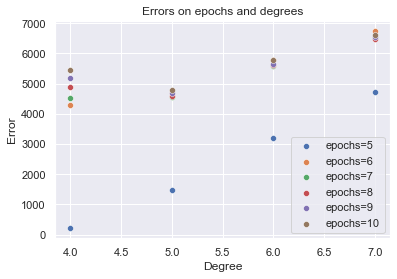

In [9]:
sns.set_theme()

for i in range(len(epochs_list)):
    sns.scatterplot(degrees_list, results[i*4:(i+1)*4], label=f'epochs={epochs_list[i]}')

plt.title('Errors on epochs and degrees')
plt.ylabel('Error')
plt.xlabel('Degree')
plt.legend()